In [1]:
import gymnasium as gym
import numpy as np 
import matplotlib.pyplot as plt
from collections import deque
import random 

In [2]:
import tensorflow as tf 
from tensorflow.keras import layers

In [3]:
# Define memory for Experience Replay
class ReplayMemory():
    def __init__(self, maxlen):
        self.memory = deque([], maxlen=maxlen)
    
    def append(self, transition):
        self.memory.append(transition)

    def sample(self, sample_size):
        return random.sample(self.memory, sample_size)

    def __len__(self):
        return len(self.memory)

In [4]:

class FrozenLakeDQL():
    # Hyperparameters
    learning_rate = 0.01
    mini_batch_size = 128
    gamma = 0.9
    target_update_freq = 32
    replay_memory_size = 1024


    def __init__(self) -> None:
        self.memory = ReplayMemory(self.replay_memory_size)
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
        self.loss_function = tf.keras.losses.MeanSquaredError()

    def create_q_model(self, input_dim, output_dim):
        model = tf.keras.Sequential()
        model.add(layers.Dense(input_shape=[input_dim], units=24, activation='relu'))
        model.add(layers.Dense(output_dim, activation="linear"))
        model.compile(optimizer = self.optimizer, loss=self.loss_function)
        return model

    def train(self, episodes, render=False, is_slippery=False):
        env = gym.make('FrozenLake-v1', map_name="4x4", is_slippery=is_slippery, render_mode='human' if render else None)
        self.num_states = env.observation_space.n
        self.num_actions = env.action_space.n

        policy_dqn = self.create_q_model(self.num_states,self.num_actions)
        target_dqn = self.create_q_model(self.num_states,self.num_actions)
        target_dqn.set_weights(policy_dqn.get_weights())

        # List to keep track of rewards collected per episode. Initialize list to 0's.
        rewards_per_episode = np.zeros(episodes)  

        # List to keep track of epsilon decay
        epsilon_history = []  

        epsilon = 1

        # Track number of steps taken. Used for syncing policy => target network.
        step_count=0
        
        for i in range(episodes):
            state = env.reset()[0]  # Initialize to state 0

            terminated = False      # True when agent falls in hole or reached goal
            truncated = False       # True when agent takes more than 200 actions    

            # Agent navigates map until it falls into hole/reaches goal (terminated), or has taken 200 actions (truncated).
            while(not terminated and not truncated):
                # Select action based on epsilon-greedy
                if random.random() < epsilon:
                    # select random action
                    action = env.action_space.sample() # actions: 0=left,1=down,2=right,3=up
                else:
                    #Select best action
                    state_dqn_input = self.state_to_dqn_input(state, self.num_states)
                    q_values = policy_dqn(tf.convert_to_tensor([state_dqn_input], dtype=tf.float32), training=False)
                    action = np.argmax(q_values[0])

                # Execute action
                new_state,reward,terminated,truncated,_ = env.step(action)  

                #Save experience into memory
                self.memory.append((state, action, new_state, reward, terminated))

                # Move to the next state
                state = new_state

                # Increment step counter
                step_count += 1 

            # Keep track of the rewards collected per episode
            if reward == 1: 
                rewards_per_episode[i] = 1 
            
            # Check if enough experience has been collected and if at least 1 reward has been collected
            if len(self.memory) > self.mini_batch_size and np.sum(rewards_per_episode)>0:
                mini_batch = self.memory.sample(self.mini_batch_size)
                self.optimize(mini_batch, policy_dqn, target_dqn)

                # Decay epsilon
                epsilon = max(epsilon -1/episodes, 0)
                epsilon_history.append(epsilon)

                # Copy policy network to target network after a certain number of steps
                if step_count > self.target_update_freq: 
                    target_dqn.set_weights(policy_dqn.get_weights())
                    step_count = 0
        
        # Close environment
        env.close()

        # Save policy
        policy_dqn.save("frozen_lake_dql.keras")

        # Create new graph 
        plt.figure(1)

        # Plot average rewards (Y-axis) vs episodes (X-axis)
        sum_rewards = np.zeros(episodes)
        for x in range(episodes):
            sum_rewards[x] = np.sum(rewards_per_episode[max(0, x-100):(x+1)])
        plt.subplot(121) # plot on a 1 row x 2 col grid, at cell 1
        plt.plot(sum_rewards)
        
        # Plot epsilon decay (Y-axis) vs episodes (X-axis)
        plt.subplot(122) # plot on a 1 row x 2 col grid, at cell 2
        plt.plot(epsilon_history)
        
        # Save plots
        plt.savefig('frozen_lake_dql.png')

    def state_to_dqn_input(self, state:int, num_states:int):
        input_tensor = np.zeros(num_states)
        input_tensor[state] = 1
        return input_tensor
    
    # Optimize policy network
    def optimize(self, mini_batch, policy_dqn, target_dqn):

        states, actions, new_states, rewards, terminals = zip(*mini_batch)

        # states = np.vstack([self.state_to_dqn_input(s, self.num_states) for s in states])
        # new_states = np.vstack([self.state_to_dqn_input(ns, self.num_states) for ns in new_states])

        states = tf.convert_to_tensor(np.vstack([self.state_to_dqn_input(s, self.num_states) for s in states]), dtype=tf.float32)
        new_states = tf.convert_to_tensor(np.vstack([self.state_to_dqn_input(ns, self.num_states) for ns in new_states]), dtype=tf.float32)
     
        # future_qs = target_dqn(new_states, training=False).numpy().max(axis=1)
        # target_qs = np.where(terminals, rewards, rewards + self.gamma * future_qs)

        # masks = tf.one_hot(actions, policy_dqn.output_shape[1])
        future_qs = tf.reduce_max(target_dqn(new_states), axis=1)
        target_qs = rewards + self.gamma * future_qs * (1 - np.array(terminals, dtype=np.float32))

        masks = tf.one_hot(actions, self.num_actions)

        with tf.GradientTape() as tape:
            q_values = policy_dqn(states)
            q_action = tf.reduce_sum(q_values * masks, axis=1)
            loss = self.loss_function(target_qs, q_action)

        grads = tape.gradient(loss, policy_dqn.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, policy_dqn.trainable_variables))

    # Run the FrozeLake environment with the learned policy
    def test(self, episodes, is_slippery=False):
        # Create FrozenLake instance
        env = gym.make('FrozenLake-v1', map_name="4x4", is_slippery=is_slippery, render_mode='human')
        num_states = env.observation_space.n
        num_actions = env.action_space.n

        # Load learned policy
        policy_dqn = tf.keras.models.load_model("frozen_lake_dql.keras")

        for i in range(episodes):
            state = env.reset()[0]  # Initialize to state 0
            terminated = False      # True when agent falls in hole or reached goal
            truncated = False       # True when agent takes more than 200 actions            

            # Agent navigates map until it falls into a hole (terminated), reaches goal (terminated), or has taken 200 actions (truncated).
            while(not terminated and not truncated):  
                # Select best action  
                tensor = tf.convert_to_tensor([self.state_to_dqn_input(state, num_states)], dtype=tf.float32) 
                action = tf.argmax(policy_dqn(tensor)[0]).numpy()

                # Execute action
                state,reward,terminated,truncated,_ = env.step(action)

        env.close()

c:\Users\maxag\Documents\GitHub\RiskBot_RL\venv_tf\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


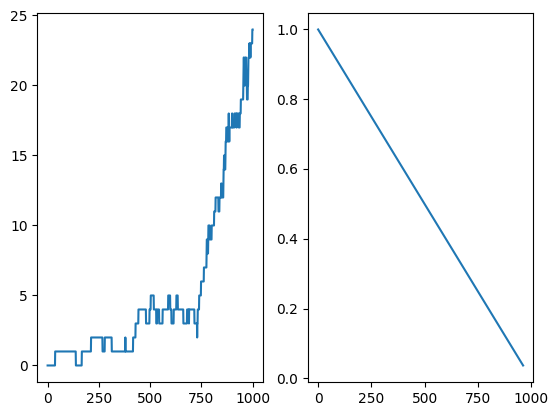

In [5]:
frozen_lake = FrozenLakeDQL()
is_slippery = True 
frozen_lake.train(1000, is_slippery=is_slippery)
frozen_lake.test(4, is_slippery=is_slippery)